In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv('LSTM-Multivariate_pollution.csv')
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [4]:

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])


In [5]:
# Convert textual features to numerical values
le = LabelEncoder()
df['wnd_dir'] = le.fit_transform(df['wnd_dir'])


In [6]:
# Select features and targets
features = df.drop(['pollution', 'temp', 'date'], axis=1)
targets = df[['pollution', 'temp']]


In [7]:

# Scale the data between 0 and 1
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_targets = MinMaxScaler()
targets_scaled = scaler_targets.fit_transform(targets)


In [9]:

# Convert data to the format required by LSTM (samples, timesteps, features)
timesteps = 10  # Number of timesteps (you can change this value)
X = []
y = []

for i in range(timesteps, len(features_scaled)):
    X.append(features_scaled[i-timesteps:i])
    y.append(targets_scaled[i])

X, y = np.array(X), np.array(y)



In [10]:
# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2))  # Since we have two targets, the number of neurons should be 2

model.compile(optimizer='adam', loss='mse')


In [12]:

# Apply EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)


In [13]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])


Epoch 1/50
876/876 [==============================] - 15s 11ms/step - loss: 0.0093 - val_loss: 0.0069
Epoch 2/50
876/876 [==============================] - 9s 11ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 3/50
876/876 [==============================] - 10s 11ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 4/50
876/876 [==============================] - 9s 10ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 5/50
876/876 [==============================] - 10s 11ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 6/50
876/876 [==============================] - 12s 13ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 7/50
876/876 [==============================] - 9s 11ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/50
876/876 [==============================] - 8s 9ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 9/50
876/876 [==============================] - 10s 11ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 10/50
876/876 [==============================] - 9s 10ms/step - loss: 0.0058 - va

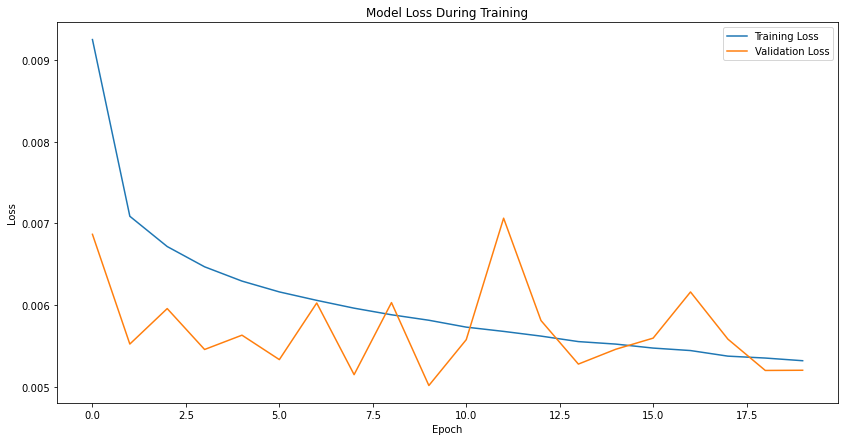

In [21]:
# Plotting the Loss for training and validation data
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [14]:

# Predict on the test data
y_pred_scaled = model.predict(X_test)

# Inverse transform the predicted and actual values back to the original scale
y_pred = scaler_targets.inverse_transform(y_pred_scaled)
y_test_actual = scaler_targets.inverse_transform(y_test)

# Display the results
print("Actual Values: \n", y_test_actual[:5])
print("Predicted Values: \n", y_pred[:5])

274/274 [==============================] - 2s 4ms/step
Actual Values: 
 [[ 65.   6.]
 [ 70.   6.]
 [ 79.   3.]
 [ 92.   4.]
 [106.   6.]]
Predicted Values: 
 [[17.03218    6.3757024]
 [16.1814     6.5423894]
 [16.241114   6.5504355]
 [34.81168    3.5929644]
 [36.77491    2.5490987]]


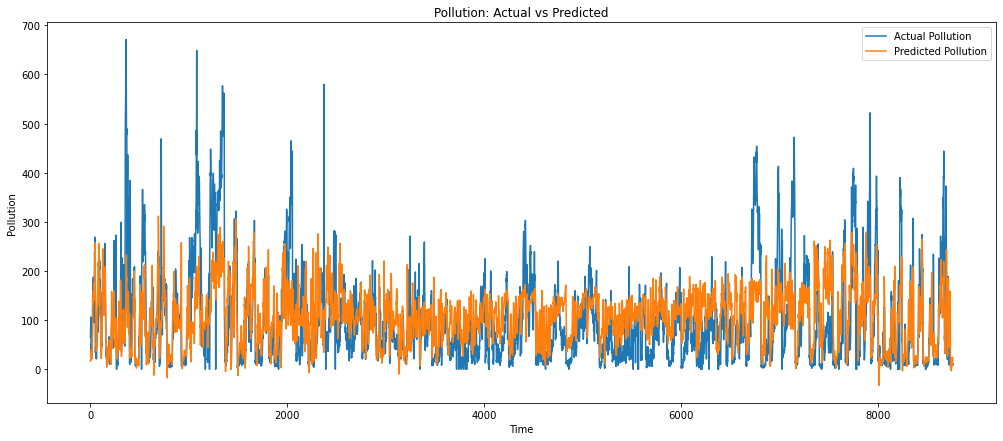

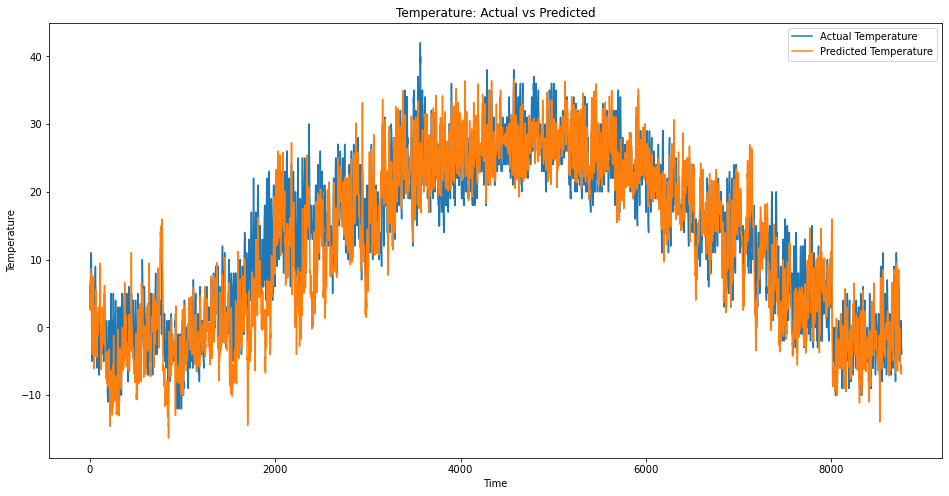

In [18]:
import matplotlib.pyplot as plt

# Actual and predicted values for pollution
plt.figure(figsize=(17, 7))
plt.plot(y_test_actual[:, 0], label='Actual Pollution')
plt.plot(y_pred[:, 0], label='Predicted Pollution')
plt.title('Pollution: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.legend()
plt.show()

# Actual and predicted values for temperature
plt.figure(figsize=(16, 8))
plt.plot(y_test_actual[:, 1], label='Actual Temperature')
plt.plot(y_pred[:, 1], label='Predicted Temperature')
plt.title('Temperature: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
